# How to use:

1. Upload PCA-Face.zip file containing all the data images

2. Change the path appropriately (in case there is any discrepancy)

3. Run All the cells except those in "DO NOT RUN THESE CELLS" section

4. The best neural network (on GPU) is mentioned and suggested to use that. In case want to check other configurations - please change the neural network configuration in the class defintion and use the other models.

# All possible Hyper-parameters:

1. Noise level
2. Neural Network
3. Type of Regularization (default: L2)
4. Learning Rate
5. Lambda value (for norm of weights in loss)
6. Type of Initialization method
7. Activation function (Note: ReLu and Leaky ReLu perform worst, so DON'T use them)
8. Number of components in PCA

# Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from PIL import Image 
from sklearn.preprocessing import OneHotEncoder
import cv2
import torch
import torch.nn as nn
from torch import optim
import dlib
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
from tqdm import tqdm_notebook 
import math
import scipy
import time
# SVM
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import string
from google.colab import files
np.random.seed(0)

# Functions Definitions

In [0]:
DEPTH = 2 ** 8

def hist_equalization(arr, depth=DEPTH):
    vals, pdf = np.unique(arr, return_counts=True)
    cdf = np.cumsum(pdf)
    min_cdf = min(cdf)
    new_vals = (
        np.round((cdf - min_cdf) / (arr.size - min_cdf) * (depth - 1))
        .astype(int))
    result = np.empty_like(arr)
    for i, val in enumerate(vals):
        result[np.nonzero(arr == val)] = new_vals[i]
    return result

def generate_distorted_image(temp,h,w,j):
  new_img = Image.fromarray(temp*(1 + noise_level*((-1)**j)*np.random.randn(h,w)))
  gray_new_img = np.array(new_img.rotate(np.random.randn()*((-1)**j)*5))

  for l in range(gray_new_img.shape[0]):
    if(gray_new_img[i][0] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][ctr],0)):
        ctr += 1
      gray_new_img[l][0:ctr] = np.ones(gray_new_img[l][0:ctr].size)*gray_new_img[l][ctr]
    if(gray_new_img[l][-1] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][-1-ctr],0)):
        ctr += 1
      gray_new_img[l][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[l][gray_new_img.shape[1]-ctr:].size)*gray_new_img[l][-1-ctr]  
  
  gray_new_img = hist_equalization(gray_new_img)
  return gray_new_img
  
def FAR_FNR(y_hat,y):
  fpr, tpr, thresholds = metrics.roc_curve(y, y_hat)
  fnr = 1-tpr
  return fpr, fnr

def detect_faces(cascade, test_image, scaleFactor = 1.1, minNeighbors= 1):
  # create a copy of the image to prevent any changes to the original one.
  image_copy = test_image.copy()
  
  #convert the test image to gray scale as opencv face detector expects gray images
  gray_image = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
  
  # Applying the haar classifier to detect faces
  faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
  
  for (x, y, w, h) in faces_rect:
    cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
      
  return image_copy, faces_rect

def cropper(im, w, h):
  width, height = im.shape[0], im.shape[1]
  
  left = (width - w)//2
  top = (height - h)//2
  right = (width + w)//2
  bottom = (height + h)//2

  return im[top:bottom, left:right]

def get_cropped_faces(cascade, test_file_names, path, crop_dims=[24,120,16,112], w=128, h=128, scaleFactor = 1.1, minNeighbors=1):
  test_images = np.zeros(h*w)
  for i in range(len(test_file_names)):
    im = np.array(Image.open(path+"{}".format(test_file_names[i])))

    # Converting to grayscale as opencv expects detector takes in input gray scale images
    #gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    #faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    faces_rect = cascade.detectMultiScale(im, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

    for (x, y, _w, _h) in faces_rect:
      crop_im = im[y:y+_h, x:x+_w]
      crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
      crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
      crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
      crop_im = hist_equalizer(crop_im)
      crop_im = cv2.cvtColor(crop_im, cv2.COLOR_RGB2GRAY)
      temp = np.array(crop_im)
      
      test_images = np.row_stack((test_images,temp.ravel()))
    
  return test_images[1:]
  
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, h, w, n_row, n_col,save_fig=False,save_dir='Output-images/',save_name='Eigen_faces'):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    if(save_fig):
      plt.savefig(save_dir+save_name+'.png')

def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    print(U[:,:n_pc].shape, S[:n_pc].shape, V[:n_pc].shape)
    print(U.shape, S.shape, V.shape)
    return projected, components, mean, centered_data

def pca_PyTorch(X, n_pc): # ensure that X is in device
    n_samples, n_features = X.shape
    mean = torch.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = torch.svd(centered_data)
    components = V.T[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    return projected, components, mean, centered_data

def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image


def hist_equalizer(im):
  img_yuv = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2YUV)
  # equalize the histogram of the Y channel
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
  # convert the YUV image back to RGB format
  im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
  return im

def get_k_acc_PyTorch(K,x_train,y_OH_train,x_test,y_OH_test):
  for k in K:
    accuracy_train = fn.accuracy_n(fn.forward(x_train),y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

    x_test =x_test.to(device)
    y_OH_test=y_OH_test.to(device)

    accuracy_test = fn.accuracy_n(fn.forward(X_test),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
#def reconstruction_PyTorch(Y, C, M, h, w, image_index):
#    n_samples, n_features = Y.shape
#    weights = torch.mm(Y, C.T)
#    centered_vector=torch.mm(weights[image_index, :], C)
#    recovered_image=(M+centered_vector).reshape(h, w)
#    return recovered_image

def accuracy_n(y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

# FFNN
def run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test,class_name="FFNNetwork_Regularized",Epochs=6000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch'):
  if(class_name == "FFNNetwork_Regularized"):
    fn = FFNNetwork_Regularized()
  elif(class_name == "FFNNetwork"):
    fn = FFNNetwork()
  loss_fn = fn.cross_entropy
  opt = optim.SGD(fn.parameters(), lr=0.9)

  device = torch.device("cuda")

  X_train = X_train.to(device)
  Y_OH_train = Y_OH_train.to(device)
  X_test = X_test.to(device)

  fn.to(device)

  tic = time.time()
  fit(X_train, Y_OH_train, fn, opt, loss_fn, epochs=Epochs)
  toc = time.time()

  print("Time for training model: {}s".format(np.round(toc-tic,3)))

  X_test =X_test.to(device)
  Y_OH_test=Y_OH_test.to(device)
  
  for k in [1,5,10]:
    accuracy_train = fn.accuracy_n(fn.forward(X_train),Y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))


    accuracy_test = fn.accuracy_n(fn.forward(X_test),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
  
  cm = confusion_matrix(torch.argmax(Y_OH_test,dim=1).to("cpu").numpy(), torch.argmax(fn.forward(X_test), dim=1).to("cpu").numpy())
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'_Confusion_matrix.png')
  else:
    plt.show()
  return fn.forward(X_test), accuracy_test

def fit(x, y, model, opt, loss_fn, epochs = 1000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch_loss'):
  
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    y_hat = model.forward(x)
    loss = loss_fn(y_hat, y)
    loss_arr.append(loss.item())
    acc_arr.append(model.accuracy(y_hat,y))
    loss.backward()
    opt.step()
    opt.zero_grad()

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  if(save_fig):
    plt.savefig(save_dir+save_name+'_loss.png')
  else:
    plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

# kNN    
def euclideanDistance(x,y):
  distance = 0
  for i in range(x.size):
    distance += (x[i] - y[i])**2
  return np.sqrt(distance)

def first_comes_first(arr,x):
    arr[1:] = arr[0:-1]
    arr[0] = x
    return arr

def kNN(test_data,train_data,train_class,k):
  test_pred = np.zeros(test_data.shape[0])
  for i in range(test_data.shape[0]):
    dist_arr = np.asarray(np.zeros(k))
    nearest = np.asarray(np.zeros(k))
    ret_arr = np.array([])
    for j in range(k):
      dist_arr[j] = euclideanDistance(train_data[j],test_data[i])
      nearest[j]=j

    for j in range(train_data.shape[0]):
      temp_dist = euclideanDistance(test_data[i],train_data[j])
      if(temp_dist <= np.amin(dist_arr)):
        dist_arr = first_comes_first(dist_arr,temp_dist)
        nearest = first_comes_first(nearest,j)

    for j in (nearest):
      ret_arr = np.append(ret_arr,train_class[int(j)])
    ret_arr = np.array([int(q) for q in ret_arr])
    test_pred[i] = np.argmax(np.bincount(ret_arr))

  return test_pred

def getAccuracy(testSet, predictions):
  correct = 0
  testSet = np.array(testSet)
  for x in range(testSet.shape[0]):
    if (testSet[x] == predictions[x]):
      correct += 1
  return (correct/float(testSet.shape[0])) * 100.0

def run_kNN(X_train,X_test,Y_OH_train,Y_OH_test,k=[1,2,3,4,5],save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_kNN'):
  acc_arr = np.zeros(len(k))
  Y_pred = np.array([])
  max_acc = 0
  for i in range(len(k)):
    if(k[i] == 0):
      continue
    else:
      test_pred = kNN(X_test, X_train, Y_train, k[i])
      acc_arr[i] = (getAccuracy(test_pred, Y_test))
      print(k[i], acc_arr[i])
  acc_arr = np.array(acc_arr)
  Y_pred = kNN(X_test, X_train, Y_train, k[np.argmax(acc_arr)])
  print("Maximum accuracy obtained for k={} : {}".format(k[np.argmax(acc_arr)],np.amax(acc_arr)))

  cm = confusion_matrix(np.argmax(Y_OH_test,axis=1), Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()

  return Y_pred, np.amax(acc_arr)  
# SVM
def run_SVM(X_train,X_test,Y_train,Y_test, print_details = False,cv = 5,save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_SVM'):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  params_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 1e-3, 0.005, 1e-4],
                      'C': [1, 10, 100, 500, 600,  725, 750, 775, 800, 900, 1000]},
                      {'kernel': ['linear'], 'C': [1, 10, 50, 100, 200, 500, 750, 1000]}]

  svm_model = GridSearchCV(SVC(), params_grid, cv=cv)
  svm_model.fit(X_train_scaled, Y_train)
  final_model = svm_model.best_estimator_
  Y_pred = final_model.predict(X_test_scaled)
  
  print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
  print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

  if(print_details):
    print('Best score for training data:', svm_model.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
    print(confusion_matrix(Y_test,Y_pred))
    print("\n")
    print(classification_report(Y_test,Y_pred))
    svm_model.score

  cm = confusion_matrix(Y_test, Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
   plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()
  return Y_pred, final_model.score(X_test_scaled  , Y_test )  

# Loading Enlarged Dataset

Variable Parameters:

1. noise_level
2. redundency_per_image

In [0]:
!unzip /content/PCA-Face.zip

In [0]:
path = "/content/PCA-Face/"

(432, 16384)
(96, 16384)
(432,)
(96,)
CPU times: user 7min 24s, sys: 566 ms, total: 7min 25s
Wall time: 7min 25s


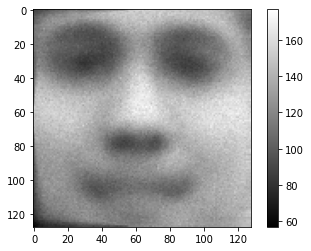

In [0]:
%%time 
n_persons = 24
non_smiling = [f"{i+1:03}" for i in range(24)]
smiling = [f"{i+1:02}" for i in range(24)]
num2alpha = dict(zip(range(1, 27), string.ascii_uppercase))
names_list = num2alpha.values()
names_list = list(names_list)

labels = non_smiling.copy()
for i,v in enumerate(smiling):
  labels.insert(2*i+1,v)
noise_level = 1
h = 128 #min(min_dim_x,min_dim_y)
w = 128 #min(min_dim_x,min_dim_y)
redundency_per_image = 5
if(redundency_per_image != 0):
  val_idx = np.random.randint(redundency_per_image, size=len(labels))
val_images = np.zeros(h*w)
train_images = np.zeros(h*w)
q = train_images.shape[0]

for i in range(len(labels)): # 
  im = Image.open(path+"{}.tga".format(labels[i]))
  #im = get_aligned_img(im)
  im = np.array(im) 
#  im = cv2.equalizeHist(im)
#  im = hist_equalizer(im)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
  temp = cv2.resize(im, (w,h), interpolation = cv2.INTER_AREA) 
  train_images = np.row_stack((train_images,cv2.equalizeHist(temp).ravel()))
  for j in range(2):
    for k in range(redundency_per_image):
      if(k == val_idx[i]):
        val_images = np.row_stack((val_images, generate_distorted_image(temp,h,w,j).ravel() ))
      else:
        train_images = np.row_stack((train_images, generate_distorted_image(temp,h,w,j).ravel() ))
  
train_images = train_images[1:]
val_images = val_images[1:]
print(train_images.shape)
print(val_images.shape)
num_faces_per_person = 2*(1+redundency_per_image*2)
Y_train = np.array([])
Y_val = np.array([])
if(redundency_per_image != 0):
  for i in range(n_persons):
    Y_train = np.append(Y_train, np.ones((num_faces_per_person-2*2))*(i+1))
    Y_val = np.append(Y_val, np.ones(2*2)*(i+1))
else:
  for i in range(n_persons):
    Y_train = np.append(Y_train, np.ones((num_faces_per_person))*(i+1))
print(Y_train.shape)
print(Y_val.shape)
mean_face = np.mean(train_images,axis=0)
plt.imshow(mean_face.reshape((h, w)), cmap=plt.cm.gray)
plt.colorbar()
plt.savefig('Output-images/mean_face.png')

# PCA

Variable Parameters:

1. n_components


In [0]:
n_components = train_images.shape[0]//8 # next 18

Y -> mean subtracted images

X_train -> Transformed data - PCA transformation

M -> Mean face

C -> Transformation matrix

All images are converted into linear 1D arrays

In [0]:
%%time
X_train, C, M, Y = pca(train_images, n_pc=n_components) # C -> (12,1444) X_train -> (48,12) M -> (1,1444) Y -> (48,1444)
eigenfaces = C.reshape((n_components, h, w)) # eigenfaces -> (50, 64, 64)
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
if(Y_val.size != 0):
  Y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
  X_val = np.matmul(val_images-M,C.T)

(432, 54) (54,) (54, 16384)
(432, 432) (432,) (16384, 16384)
CPU times: user 2min 48s, sys: 4.73 s, total: 2min 52s
Wall time: 49.2 s


Eigen Faces (Number of components = 54)


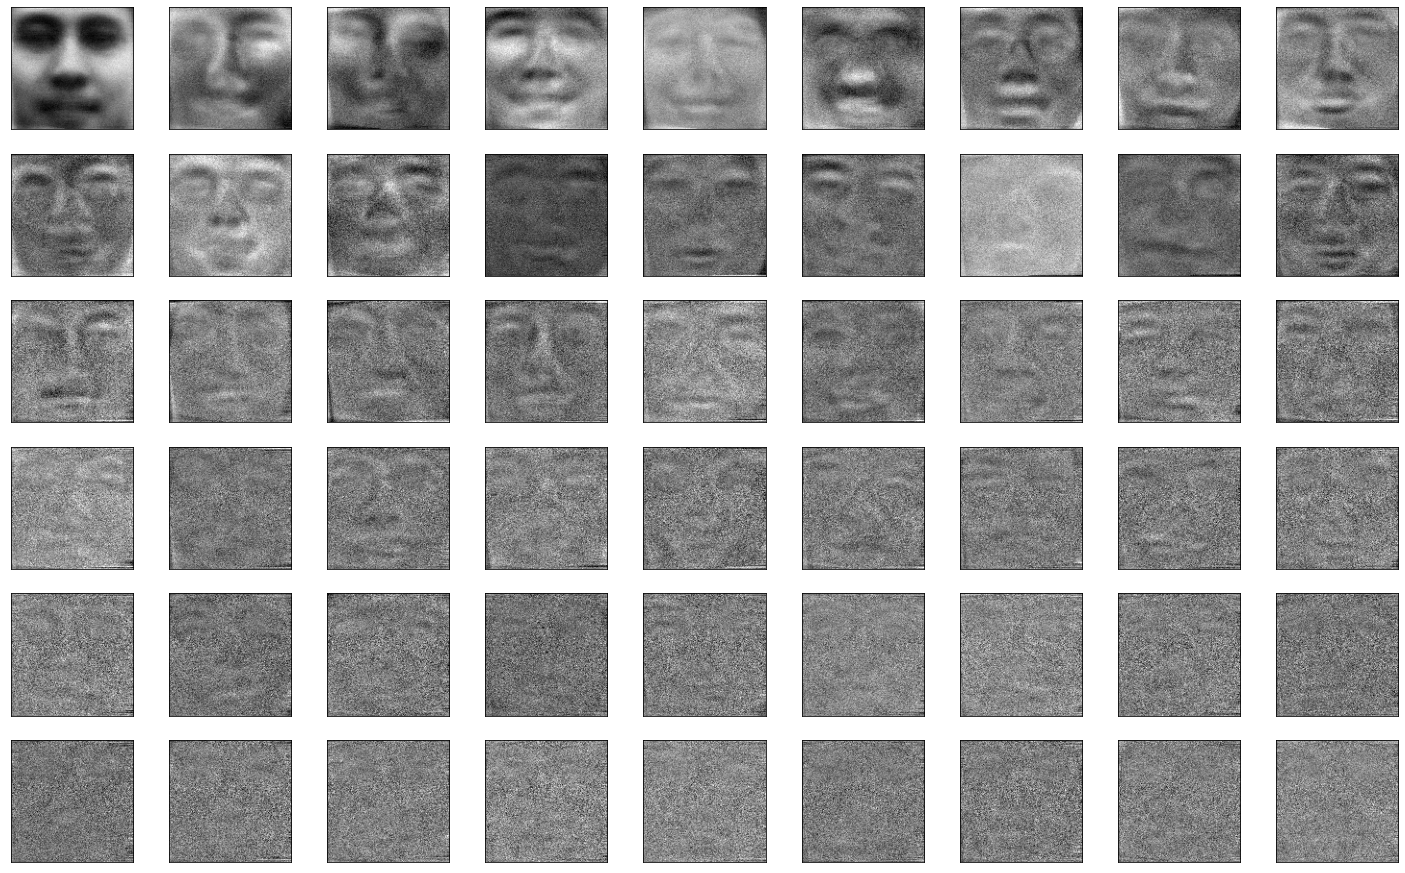

In [0]:
print("Eigen Faces (Number of components = {})".format(n_components))
plot_portraits(eigenfaces, h, w, 6, 9,save_fig=True,save_dir='Output-images/',save_name='Eigen_faces_54')

### Reconstructing training set images

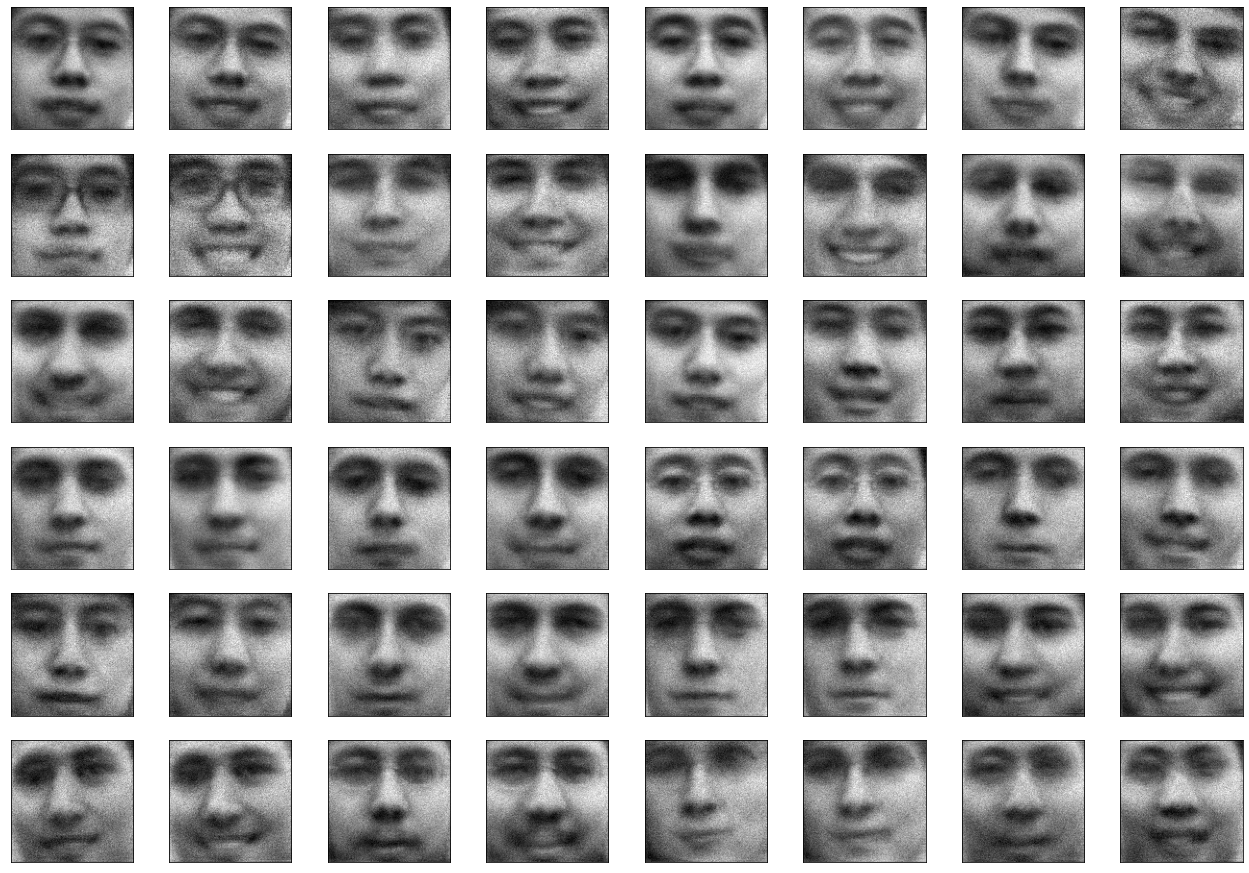

In [0]:
re_train_images=np.array([reconstruction(Y, C, M, h, w, i) for i in range(train_images.shape[0])])
plot_portraits(re_train_images[::9], h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Training_samples')

### Reconstructing validation set images

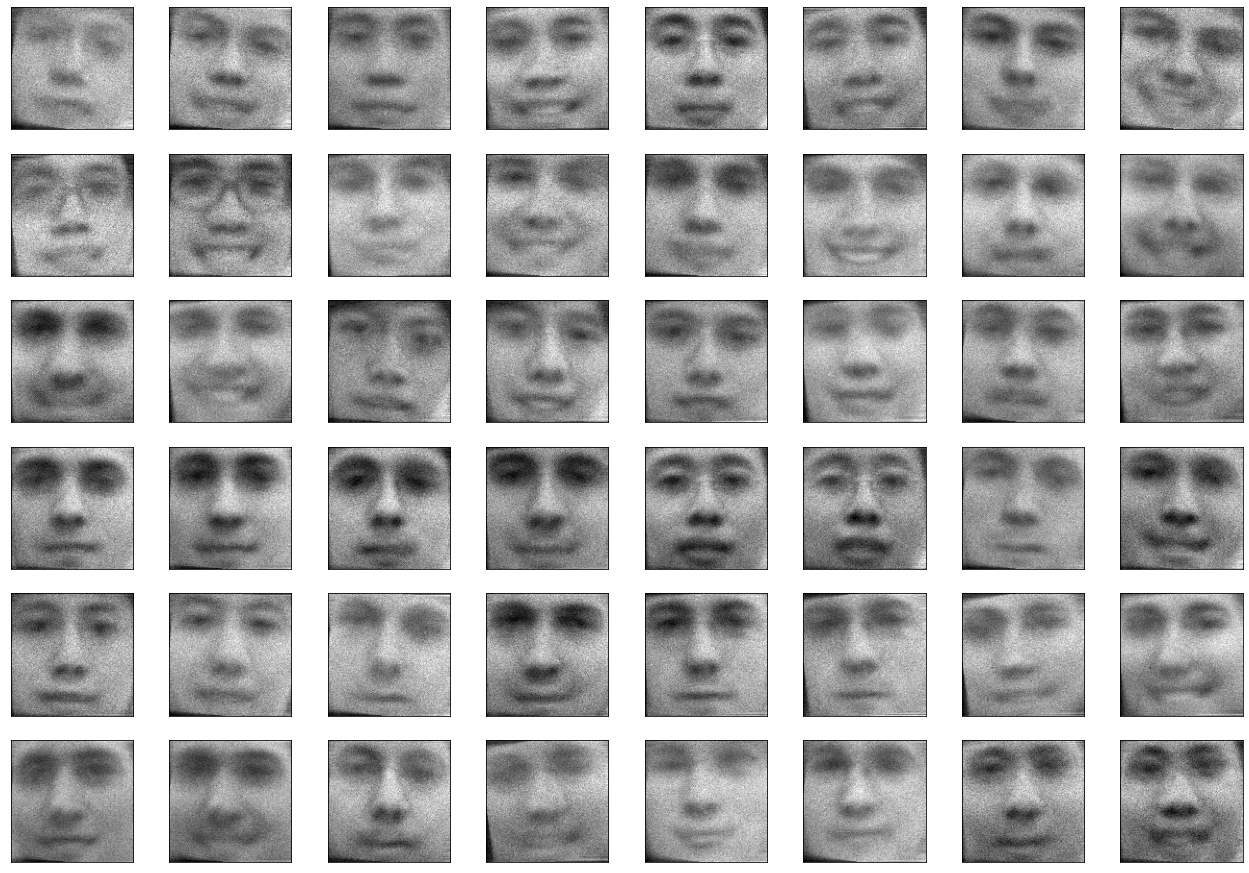

In [0]:
re_val_images = np.array([reconstruction(val_images-M, C, M, h, w, i) for i in range(val_images.shape[0])])
plot_portraits(re_val_images[::2], h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Validation_samples')

# Reference: 
1. https://github.com/parulnith/Face-Detection-in-Python-using-OpenCV/blob/master/Face%20Detection%20with%20OpenCV-Python.ipynb

2. https://medium.com/@alkeshab/face-detection-using-opencv-in-google-colaboratory-a7529a2bb921

3. https://www.datacamp.com/community/tutorials/face-detection-python-opencv

# Using OpenCV's Pre-Trained Haar Classifier for face detection

(Justification: The face detection classifier, if to be designed and trained, requires thousands of images. As the large dataset is not available, we resort to using the pre-trained Haar-features based classifier by tuning the free-parameters)

In [0]:
!apt-get -qq install -y libsm6 libxext6

In [0]:
# running this cell once, produces error at first, so rerun the cell
!pip install -q -U opencv-python 


## Haar cascade files

OpenCV comes with a lot of pre-trained classsifiers. For instance there are classifiers for smile, eyes,face etc. These come in the form of xml files and are located in opencv/data/haarcascades/ folder. However, just to make things simple, you can also access them from here. Download the xml files and place them in data folder in the same working directory as the jupyter notebook.


### Loading the classifier for frontal face

In [0]:
haar_cascade_face = cv2.CascadeClassifier(path+'haarcascade_frontalface_alt.xml')


## Face detection

We shall be using the detectMultiscale module of the classifier.This function will return the co-ordinates(x and y posiiton plus the height and width) of the detected faces as Rect(x,y,w,h).

Found values of parameters: scaleFactor = 1.1 minNeighbors = 1 file used = "haarcascade_frontalface_alt.xml"

Then we loop over all the co-ordinates it returned and draw rectangles around them using Open CV.We will be drawing a green rectangle with thicknessof 2

Finally, we shall display the original image in coloured to see if the face has been detected correctly or not.

## Only for Visualizing Face Detection

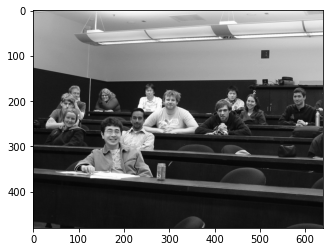

In [0]:
# Loading the image to be tested
test_image = Image.open(path+"IMG_0002.tga")
test_image = np.array(test_image) 

# Converting to grayscale as opencv expects detector takes in input gray scale images
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Displaying grayscale image
plt.imshow(test_image_gray, cmap='gray')

Faces found:  12


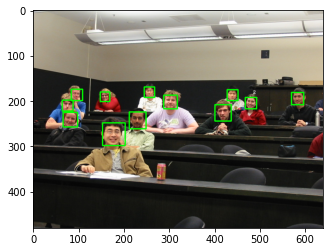

In [0]:
faces_rects = haar_cascade_face.detectMultiScale(test_image_gray, scaleFactor = 1.1, minNeighbors = 1)
# Let us print the no. of faces found
#convert image to RGB and show image
print('Faces found: ', len(faces_rects))

for (x,y,w,h) in faces_rects:
     cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(test_image)

## Detecting and Extracting Faces from Test Images

In [0]:
n_test_imgs = 18
rare_people = ["bush_george_w_portrait.tga", "elf.png"] # Note: using png file for "elf" as the tga file showed OS error (?)
less_people = []
more_people = []
n_less_people = 16
n_more_people = 2
#h = 128
#w = 128
for i in range(n_less_people):
  less_people.append("IMG_0{}.tga".format(non_smiling[i+n_more_people])) 
for i in range(n_more_people):
  more_people.append("IMG_0{}.tga".format(non_smiling[i])) 

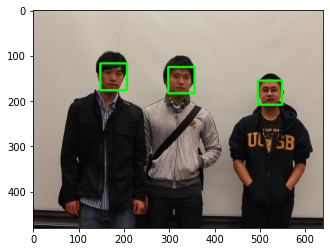

In [0]:
# Randomly plotting the test images -- showing succesful face detection
for i in range(4):
  im = np.array(Image.open(path+"IMG_000{}.tga".format((i+1)*2 + 1)))
  faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.2, minNeighbors=5)

  for (x, y, _w, _h) in faces_rect:
    cv2.rectangle(im,(x,y),(x+_w,y+_h),(0, 255, 0),4)
  plt.imshow(im)
  plt.savefig("{}.png".format(i+1))

### Use these cells to decide the crop coordinates that makes the test images appear identical to training set images (best values found so far fed into test images generating function's default arguments)

In [0]:
i = 0
im = np.array(Image.open(path+"/IMG_0003.tga"))

faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.2, minNeighbors=5)
temp0 = np.array([])
temp1 = np.array([])
temp2 = np.array([])
ctr = 0
w = 128
h = 128
for (x, y, _w, _h) in faces_rect:
  crop_im = im[y:y+_h, x:x+_w]
  crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  #crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
  #crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  crop_im = hist_equalizer(crop_im)
  #crop_im = cv2.cvtColor(crop_im, cv2.COLOR_RGB2GRAY)
  if(ctr == 0):
    temp0 = np.array(crop_im)
  if(ctr == 1):
    temp1 = np.array(crop_im)
  if(ctr == 2):
    temp2 = np.array(crop_im)
  ctr +=1

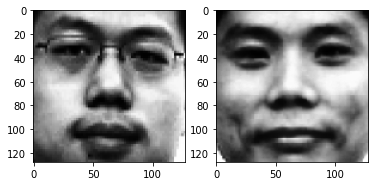

In [0]:
temp_img = hist_equalizer(cv2.resize(temp1[24:120,16:112], (w,h), interpolation = cv2.INTER_AREA))
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(train_images[0].reshape((h, w)), cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(temp_img , cmap=plt.cm.gray)
plt.savefig('Output-images/Training_image_vs_cropped_image.png')

### Generating Test Images

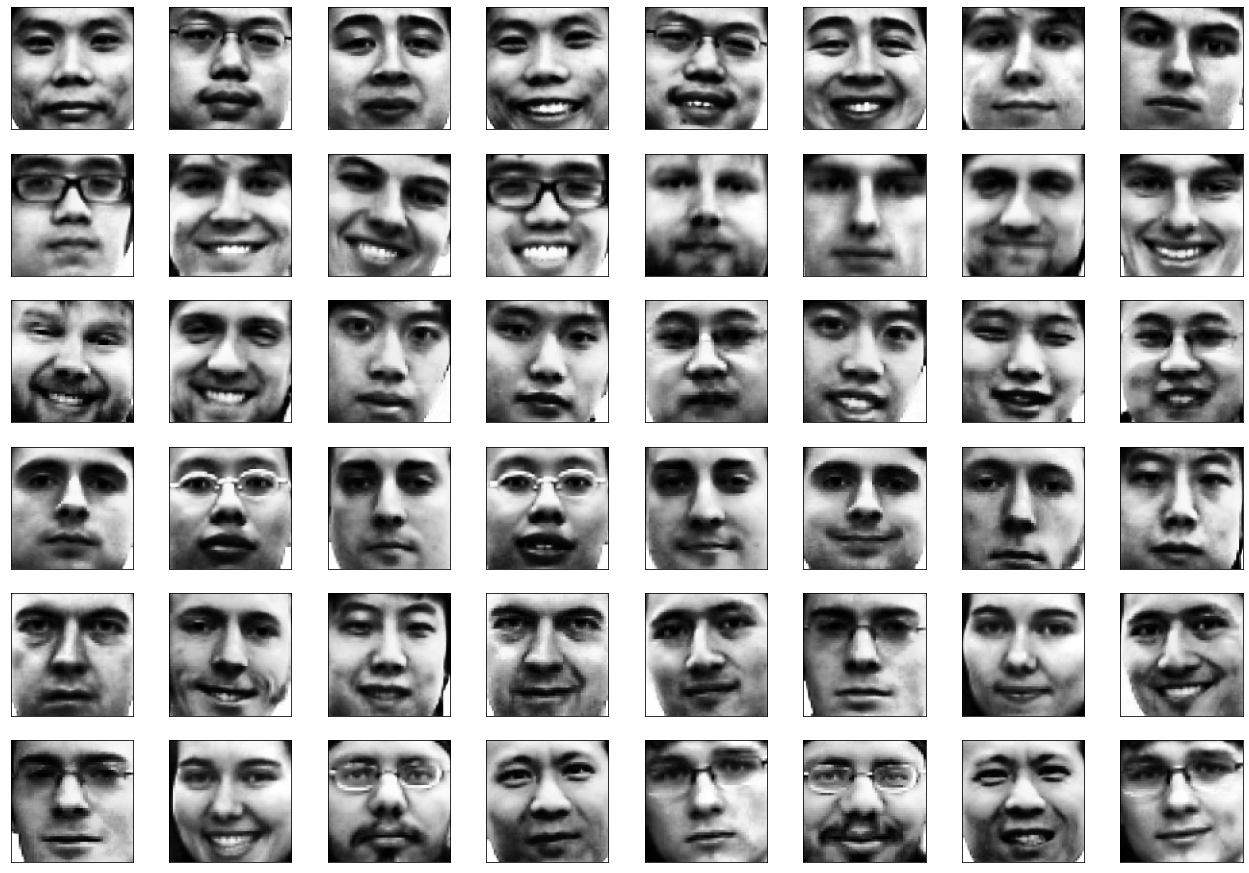

In [0]:
#test_images_r, test_images_g, test_images_b = get_cropped_faces(haar_cascade_face, test_file_names)
test_images = get_cropped_faces(haar_cascade_face, less_people,scaleFactor=1.2, minNeighbors=5,path=path)
# labels of the test images -- manually identified
Y_test = np.array([2,1,3,2,1,3,6,4,5,6,4,5,8,7,9,7,9,8,10,11,12,10,11,12,14,15,13,15,13,14,16,17,18,16,17,18,21,19,20,21,19,20,22,24,23,22,24,23])
Y_OH_test = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
X_test = np.matmul(test_images-M,C.T)
plot_portraits(test_images, h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Testing_samples')

### Reconstructing Test faces

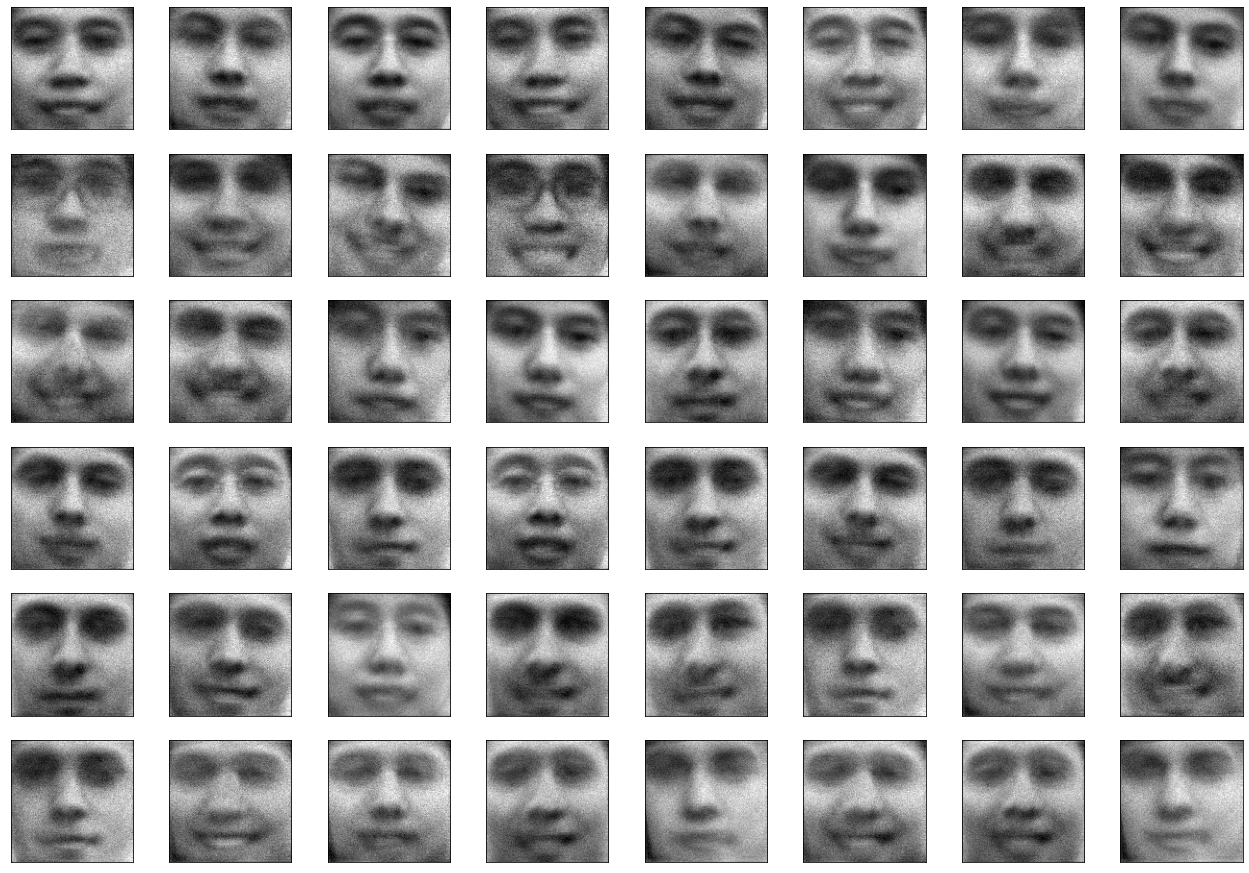

In [0]:
re_test_images=np.array([reconstruction(test_images-M, C, M, h, w, i) for i in range(test_images.shape[0])])
plot_portraits(re_test_images, h, w, 6, 8,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Testing_samples')

# Normalization

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# k-NN Based Classification

1 64.58333333333334
2 29.166666666666668
3 27.083333333333332
4 16.666666666666664
5 10.416666666666668
Maximum accuracy obtained for k=1 : 64.58333333333334


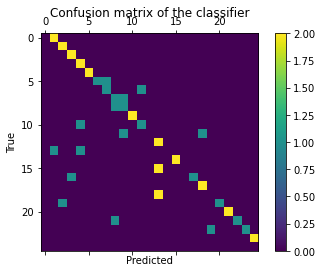

In [0]:
Y_pred_kNN, accuracy_kNN = run_kNN(X_train,X_test,Y_OH_train,Y_OH_test,save_fig=True)
#Y_pred_kNN, accuracy_kNN = run_kNN(X_train.to("cpu").detach().numpy(),X_test.to("cpu").detach().numpy(),Y_OH_train.to("cpu").detach().numpy(),Y_OH_test.to("cpu").detach().numpy())

# Support Vector Machine Based Classification

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.729167
Best score for training data: 0.907324244854317 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.01 

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


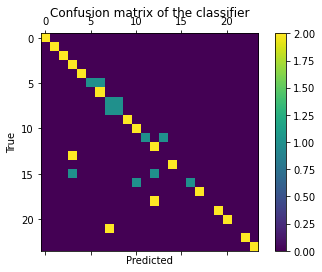

In [0]:
Y_pred_SVM, accuracy_SVM = run_SVM(X_train_scaled,X_test_scaled,Y_train,Y_test,print_details=True,save_fig=True)

# Training A Neural Network on CPU

Variable Parameters:

1. num_hidden
2. init_method
3. activation_function
4. leaky_slope (applies if using leaky ReLu as activation function)

## Class Definition

In [0]:
class FFNetwork:
  
  def __init__(self, num_hidden=250, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.num_layers=2
    self.layer_sizes = [n_components, num_hidden, n_persons]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)
    
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
    
  def get_accuracy(self):    
    Y_pred_train = self.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = self.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = self.accuracy(Y_pred_train, Y_train)
    accuracy_val = self.accuracy(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
    self.H2 = self.softmax(self.A2) # (N, 2)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD",l2_norm=False, lambda_val=0.8, display_loss=False, eta=1, save_fig = False, save_dir='Output-images/',save_name='FFNN_Regularization'):
    train_accuracies={}
    val_accuracies={}
    if display_loss:
      loss = []
      weight_mag = []
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      self.grad(X, Y)
      for i in range(1,self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      train_accuracy,val_accuracy=self.get_accuracy()
      train_accuracies[num_epoch]=train_accuracy
      val_accuracies[num_epoch]=val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(self.cross_entropy(Y, Y_pred))
        weight_mag.append((np.linalg.norm(self.params["W1"]) + np.linalg.norm(self.params["W2"]) + np.linalg.norm(self.params["B1"]) + np.linalg.norm(self.params["B2"]))/18)
        
    plt.plot(list(train_accuracies.values()),label="Train accuracy")
    plt.plot(list(val_accuracies.values()),label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*(1/n_persons))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if(save_fig):
      plt.savefig(save_dir+save_name+'accuracy.png')
    else:
      plt.show()

    if display_loss:
      fig, ax1 = plt.subplots()
      color = 'tab:red'
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()  
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)  # we already handled the x-label with ax1
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout() 
      if(save_fig):
        plt.savefig(save_dir+save_name+'.png')
      else:
        plt.show()


  def accuracy(self,y_hat, y):
    ctr = 0.0
    for i in range(y.size):
      if(y_hat[i] == (y[i]-1)):
        ctr += 1.0
    return ctr/y.size

  def cross_entropy(self,label,pred):
    yl= pred*label
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def log_loss(self,yt,yp):
    yp = np.argmax(yp, axis=1)
    return -(yt*np.log(yp) + (1 - yt)*np.log(1 - yp))

  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze() 

  def accuracy_n(self,y_hat, y,topk=(1,)):
    y_hat,y = map(torch.tensor, (y_hat,y))
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    y_hat = y_hat.numpy()
    y = y.numpy()
    return res
  

In [0]:
def print_accuracy(model):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = model.accuracy(Y_pred_train, Y_train)
    accuracy_val = model.accuracy(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

## Without L2 Regularization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


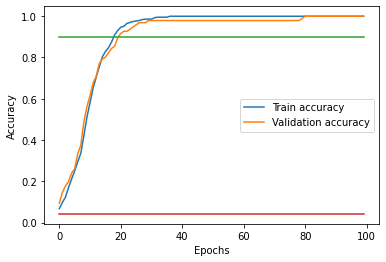

Model Training time: 2.0255815982818604
Training accuracy 1.0
Validation accuracy 1.0
CPU times: user 3.27 s, sys: 4.31 s, total: 7.58 s
Wall time: 2.04 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


In [0]:
%%time
# num_hidden=250, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
model = FFNetwork(num_hidden=250)
tic = time.time()
model.fit(X_train, Y_OH_train, epochs=100, eta=0.1)
toc = time.time()
print("Model Training time: {}".format(toc-tic))
print_accuracy(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


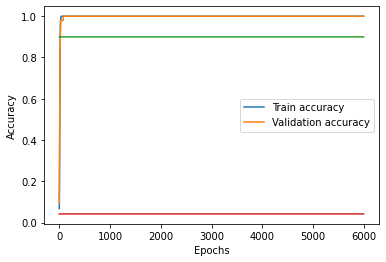

Model Training time: 103.66418886184692
Training accuracy 1.0
Validation accuracy 1.0
CPU times: user 2min 54s, sys: 3min 48s, total: 6min 42s
Wall time: 1min 43s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


In [0]:
%%time
# num_hidden=250, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
model = FFNetwork(num_hidden=250)
tic = time.time()
model.fit(X_train, Y_OH_train, epochs=6000, eta=0.1)
toc = time.time()
print("Model Training time: {}".format(toc-tic))
print_accuracy(model)

## With L2 Regularization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp



Model Training time: 23.906169176101685
Training accuracy 1.0
Validation accuracy 1.0
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 75.0


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 97.91666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


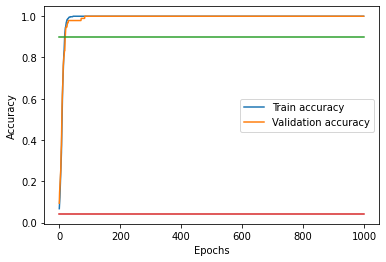

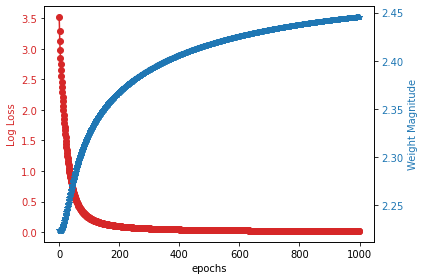

In [0]:
# MODEL -> 1
model = FFNetwork(num_hidden=250)
tic = time.time()
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.1, l2_norm=True, lambda_val=0.1, display_loss=True, save_fig = True, save_dir='Output-images/', save_name='FFNN_with_regularization_1')
toc = time.time()
print("Model Training time: {}".format(toc-tic))

print_accuracy(model)
for k in [1,5,10]:
  accuracy_train = model.accuracy_n(model.predict(X_train),Y_OH_train, topk=(k,))[0].item()
  print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

  accuracy_test = model.accuracy_n(model.predict(X_test),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
  print('\n')

### Models with following parameters:

1. Activation function: Sigmoid

2. Number of Neurons in hidden layer: 250

3. Initialization Method: Xavier

4. lambda_val : VARIABLE

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp



Model Training time: 24.018743991851807
Training accuracy 1.0
Validation accuracy 1.0
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 77.08332824707031


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 97.91666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


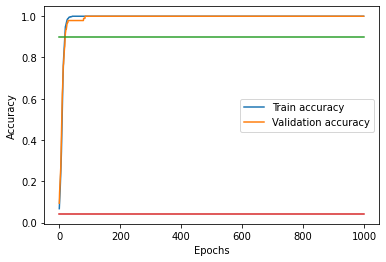

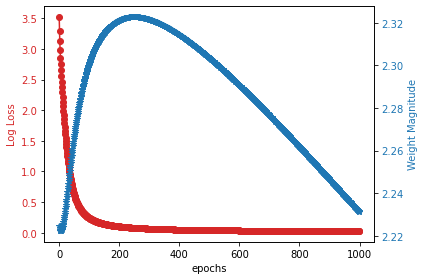

In [0]:
# MODEL -> 1
model = FFNetwork(num_hidden=250)
tic = time.time()
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.1, l2_norm=True, lambda_val=1, display_loss=True, save_fig = True, save_dir='Output-images/', save_name='FFNN_with_regularization_1')
toc = time.time()
print("Model Training time: {}".format(toc-tic))

print_accuracy(model)
for k in [1,5,10]:
  accuracy_train = model.accuracy_n(model.predict(X_train),Y_OH_train, topk=(k,))[0].item()
  print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

  accuracy_test = model.accuracy_n(model.predict(X_test),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
  print('\n')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


Training accuracy 1.0
Validation accuracy 1.0
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 70.83332824707031


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 97.91666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




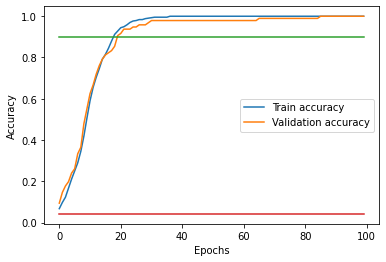

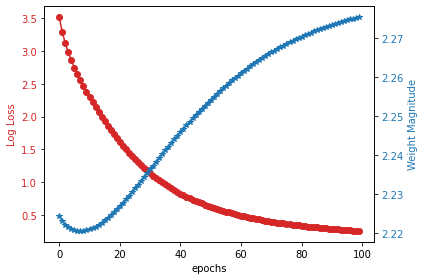

In [0]:
# MODEL -> 2
model = FFNetwork(num_hidden=250, )
model.fit(X_train, Y_OH_train, epochs=100, eta=0.1, l2_norm=True, lambda_val=2, display_loss=True,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_regularization_2')
print_accuracy(model)

for k in [1,5,10]:
  accuracy_train = model.accuracy_n(model.predict(X_train),Y_OH_train, topk=(k,))[0].item()
  print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

  accuracy_test = model.accuracy_n(model.predict(X_test),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
  print('\n')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


Training accuracy 1.0
Validation accuracy 1.0
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 68.75


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 97.91666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




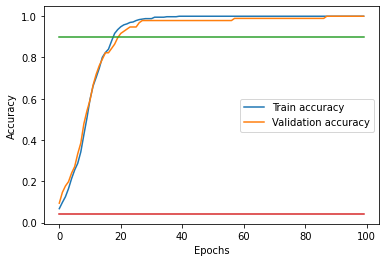

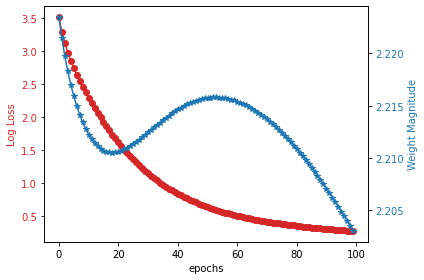

In [0]:
# MODEL -> 3
model = FFNetwork(num_hidden=250, )
model.fit(X_train, Y_OH_train, epochs=100, eta=0.1, l2_norm=True, lambda_val=5, display_loss=True, save_fig = True, save_dir='Output-images/', save_name='FFNN_with_regularization_5')
print_accuracy(model)
for k in [1,5,10]:
  accuracy_train = model.accuracy_n(model.predict(X_train),Y_OH_train, topk=(k,))[0].item()
  print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

  accuracy_test = model.accuracy_n(model.predict(X_test),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
  print('\n')

### Models with following parameters:

1. Activation function: Tanh

2. Number of Neurons in hidden layer: 250

3. Initialization Method: Xavier

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


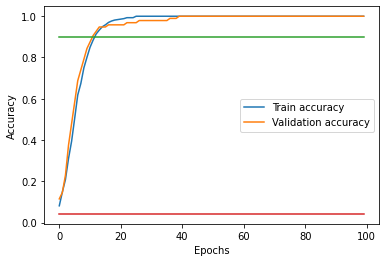

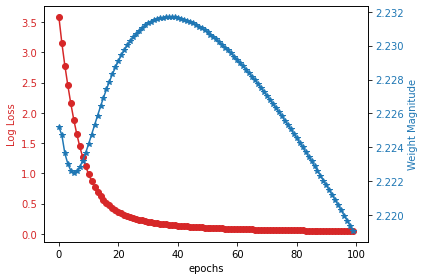

Training accuracy 1.0
Validation accuracy 1.0
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 68.75


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 97.91666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




In [0]:
# MODEL -> 1
model = FFNetwork(num_hidden=250, activation_function='tanh')
model.fit(X_train, Y_OH_train, epochs=100, eta=0.1, l2_norm=True, lambda_val=2, display_loss=True)
print_accuracy(model)
for k in [1,5,10]:
  accuracy_train = model.accuracy_n(model.predict(X_train),Y_OH_train, topk=(k,))[0].item()
  print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

  accuracy_test = model.accuracy_n(model.predict(X_test),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
  print('\n')

# Difference Based Classifier -- FAILED
(Reconstructing faces from considered Principal components and finding difference between training and testing image, to classify test images by method of least residuals )

(This was the method mentioned in the webpage from which the data set was used)

In [0]:
if(re_test_images.shape[0] == re_train_images.shape[0]):
  diff = np.abs(re_test_images - re_train_images)
  diff = diff.ravel()
  diff = diff.reshape(re_test_images.shape[0], h*w)
  res = np.argmin(np.matmul(diff, diff.T),axis=1)
  res += 1
  ctr = 0
  for i in range(res.shape[0]):
    if(Y_test[i] == res[i]):
      ctr += 1
  print("Accuracy on test dataset: ", (ctr/res.shape[0])*100,"%") 

# Porting to PyTorch

In [0]:
X_train, X_val, X_test = map(torch.tensor, (X_train, X_val, X_test))

X_train = X_train.float()
X_val = X_val.float()
X_test = X_test.float()

X_train_scaled, Y_OH_train, Y_train, X_val_scaled, Y_OH_val, Y_val, X_test_scaled, Y_OH_test, Y_test = map(torch.tensor, (X_train_scaled, Y_OH_train, Y_train, X_val_scaled, Y_OH_val, Y_val, X_test_scaled, Y_OH_test, Y_test))

X_train_scaled = X_train_scaled.float()
Y_train = Y_train.long()

X_val_scaled = X_val_scaled.float()
Y_val = Y_val.long()
X_test_scaled = X_test_scaled.float()
Y_test = Y_test.long()

# Training A Neural Network on GPU

Variable Parameters:

1. Neural Network
3. Activation function

## Un-Regularized

### Class Definition

Variable Parameters:

1. Activation function (Sigmoid or Tanh only -- or mixed)
2. Number of neurons in the hidden layer
3. Number of hidden layers

(last activation function should be Softmax or of same kind)

In [0]:
class FFNNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(n_components, 250), 
#        nn.Sigmoid(), 
        nn.Tanh(),
        nn.Linear(250, n_persons), 
#        nn.Sigmoid(), 
#        nn.Tanh(),
#        nn.Linear(40, n_persons), 
#        nn.Sigmoid(), 
#        nn.Tanh(),
#        nn.Linear(n_persons, n_persons), 
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl

  def accuracy(self,y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == torch.argmax(y, dim=1)).float().mean()

  def predict(self, X):
    Y_pred = self.forward(x)
    return np.array(Y_pred).squeeze()
  
  def accuracy_n(self,y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res
  

### Fitting

Variable Parameters:

1. Optimization algorithm
2. Loss function

By default,
1. Stochastic GD used for faster convergence
2. Cross Entropy Loss used for loss function

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 3.279929639851161
Loss after training 7.470954679463219e-05
Time for training model: 8.183s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 72.91666412353516


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 97.91666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 100.0




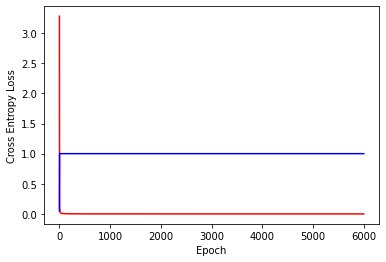

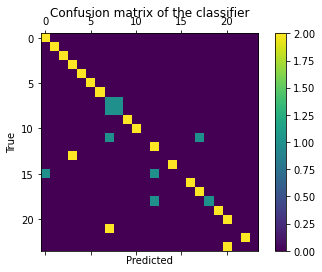

In [0]:
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test,"FFNNetwork")

## Regularized

### Class Definition

Variable Parameters:

1. Number of neurons in hidden layer(s)
2. Number of hidden layers
3. Activation function 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 3.2151319902421087
Loss after training 1.4146413581932566
Time for training model: 16.611s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 66.66666412353516


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 93.75


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




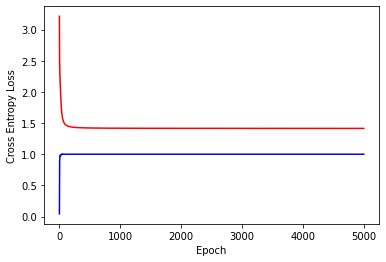

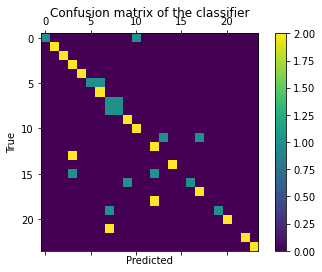

In [0]:
class RegularizedLinear(nn.Linear):
    def __init__(self, *args, ar_weight=1e-3, l1_weight=1e-3, l2_weight=2, **kwargs):
        super(RegularizedLinear, self).__init__(*args, **kwargs)
        #self.ar_weight = ar_weight
        #self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self._losses = {}

    def forward(self, input):
        output = super(RegularizedLinear, self).forward(input)
        #self._losses['activity_regularization'] = (output * output).sum() * self.ar_weight
        #self._losses['l1_weight_regularization'] = torch.abs(self.weight).sum() * self.l1_weight
        self._losses['l2_weight_regularization'] = torch.abs(torch.mul(self.weight,self.weight)).sum() * self.l2_weight
        return output

class FFNNetwork_Regularized(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        RegularizedLinear(n_components, 250), 
        nn.BatchNorm1d(250),
        #nn.Dropout(0.2),
        nn.Tanh(),
        RegularizedLinear(250,150), 
        nn.BatchNorm1d(150),
        nn.Dropout(0.2),
        nn.Tanh(),
        RegularizedLinear(150, n_persons), 
        nn.BatchNorm1d(n_persons),
#        nn.Dropout(0.5),
        nn.Tanh(),   
        RegularizedLinear(n_persons, n_persons), 
        nn.BatchNorm1d(n_persons),
#        nn.Dropout(0.1),
        nn.Tanh(),   
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

  def softmax(self,x):
    return torch.exp(x)/torch.sum(torch.exp(x))

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl

  def accuracy(self,y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == torch.argmax(y, dim=1)).float().mean()

  def predict(self, X):
    Y_pred = self.forward(x)
    return np.array(Y_pred).squeeze()
  
  def accuracy_n(self,y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

Y_pred_FFNN, accuracy_FFNN, model = run_FFNN(X_train_scaled,X_test_scaled,Y_OH_train,Y_OH_test,Epochs=10000,save_fig=True)

### MODEL: (Best possible Combination found so far)

1. Configuration: (n_components,250,40,n_persons)
2. Activation function: tanh

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 3.2194279314307237
Loss after training 1.414496030156609
Time for training model: 20.563s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 77.08332824707031


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 91.66666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516


CPU times: user 19.3 s, sys: 822 ms, total: 20.2 s
Wall time: 20.7 s


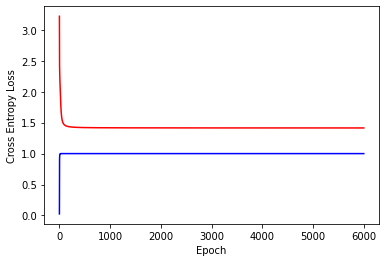

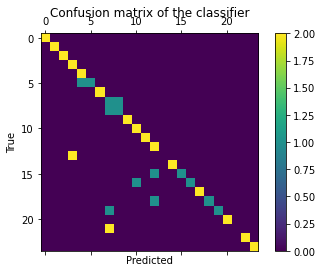

In [0]:
%%time
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test,Epochs=6000,save_fig=True)

# ENSEMBLE CLASSIFIER

Vote weighted according to individual classifier accuracy score on test data

In [0]:
Y_pred_FFNN = Y_pred_FFNN.to("cpu").detach().numpy()
Y_pred_FFNN = np.argmax(Y_pred_FFNN,axis=1)
Y_pred_FFNN += 1

In [0]:
Y_OH_kNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_kNN,np.arange(n_persons+1)[1:]),1)).toarray()[0:Y_pred_kNN.size]
Y_OH_SVM = enc.fit_transform(np.expand_dims(np.append(Y_pred_SVM,np.arange(n_persons+1)[1:]),1)).toarray()[0:Y_pred_SVM.size]
Y_OH_FFNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_FFNN,np.arange(n_persons+1)[1:]),1)).toarray()[0:Y_pred_FFNN.size]

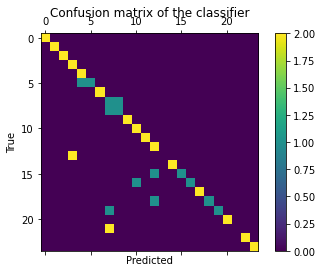

In [0]:
save_fig = True
save_dir = "Output-images/"
save_name = "Confusion_matrix_ensemble"
consider = 2
if(consider == 3):
  weightage = [accuracy_kNN,accuracy_SVM,accuracy_FFNN]
  weightage /= sum(weightage)
  temp_Y_pred_ensemble = weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN 
  Y_pred_ensemble = np.argmax(weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN , axis=1)
  Y_pred_ensemble += 1  
  cm = confusion_matrix(Y_test, Y_pred_ensemble)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+"_(kNN_SVM_FFNN).png")
  else:
    plt.show()

elif(consider == 2):
  weightage = [accuracy_SVM,accuracy_FFNN]
  weightage /= sum(weightage)
  temp_Y_pred_ensemble = weightage[0]*Y_OH_SVM + weightage[1]*Y_OH_FFNN 
  Y_pred_ensemble = np.argmax(weightage[0]*Y_OH_SVM + weightage[1]*Y_OH_FFNN , axis=1)
  Y_pred_ensemble += 1
  cm = confusion_matrix(Y_test, Y_pred_ensemble)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+"_(SVM_FFNN).png")
  else:
    plt.show()


In [0]:
# considering kNN, SVM and FFNN
for k in [1,5,10]:
  accuracy_test = accuracy_n(torch.tensor(temp_Y_pred_ensemble),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))

Testing Accuracy (top-1): 77.08332824707031
Testing Accuracy (top-5): 87.5
Testing Accuracy (top-10): 91.66666412353516


In [0]:
# considering only SVM and FFNN
for k in [1,5,10]:
  accuracy_test = accuracy_n(torch.tensor(temp_Y_pred_ensemble),Y_OH_test, topk=(k,))[0].item()
  print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))

Testing Accuracy (top-1): 77.08332824707031
Testing Accuracy (top-5): 85.41666412353516
Testing Accuracy (top-10): 93.75


# Downloading All Saved Plots


In [0]:
!zip -r /content/Output-images.zip /content/Output-images

  adding: content/Output-images/ (stored 0%)
  adding: content/Output-images/FFNN_with_PyTorch_loss_loss.png (deflated 12%)
  adding: content/Output-images/Confusion_matrix_ensemble_(SVM_FFNN).png (deflated 10%)
  adding: content/Output-images/mean_face.png (deflated 3%)
  adding: content/Output-images/Reconstructed_Training_samples.png (deflated 3%)
  adding: content/Output-images/FFNN_with_PyTorch_Confusion_matrix.png (deflated 10%)
  adding: content/Output-images/Confusion_matrix_ensemble_(kNN_SVM_FFNN).png (deflated 10%)
  adding: content/Output-images/Confusion_matrix_kNN.png (deflated 11%)
  adding: content/Output-images/Reconstructed_Testing_samples.png (deflated 3%)
  adding: content/Output-images/Testing_samples.png (deflated 2%)
  adding: content/Output-images/Reconstructed_Validation_samples.png (deflated 3%)
  adding: content/Output-images/Eigen_faces_54.png (deflated 4%)
  adding: content/Output-images/Confusion_matrix_SVM.png (deflated 10%)


In [0]:
files.download("/content/Output-images.zip")

# Other Models Tried (use these if want to experiment with other neural networks)

### MODEL 1:

1. Configuration: (n_components,250,n_persons)
2. Activation function: tanh

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 3.2174928758122343
Loss after training 1.4146777307571836
Time for training model: 12.361s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 77.08332824707031


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 97.91666412353516


Training Accuracy (top-10): 100.0
Testing Accuracy (top-10): 97.91666412353516




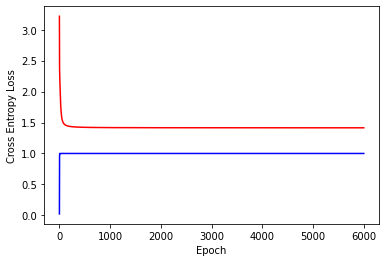

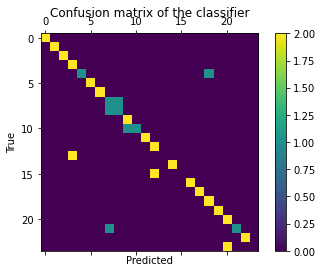

In [0]:
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test)

### MODEL 2:

1. Configuration: (n_components,250,n_persons)
2. Activation function: sigmoid


In [0]:
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test)

### MODEL 4:

1. Configuration: (n_components,250,n_persons,n_persons)
2. Activation function: tanh,sigmoid,tanh, softmax

In [0]:
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test)

### MODEL 5:

1. Configuration: (n_components,250,40,n_persons)
2. Activation function: tanh,sigmoid,tanh,softmax


In [0]:
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test)

### MODEL 6:

1. Configuration: (n_components,250,40,n_persons)
2. Activation function: sigmoid,tanh,sigmoid,softmax


In [0]:
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test)

### MODEL 7:

1. Configuration: (n_components,250,150,n_persons)
2. Activation function: sigmoid,tanh,sigmoid,softmax



In [0]:
Y_pred_FFNN, accuracy_FFNN = run_FFNN(X_train,X_test,Y_OH_train,Y_OH_test)

# DO NOT RUN THE CELLS BELOW:

## CNN 

Modified form of LeNet Architecture was tried: accuracy on training set = 0

In [0]:
class LeNet(nn.Module):
  def __init__(self): 
    super(LeNet, self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(1, 6, 5),         # (N, 1, 128, 128) -> (N,  6, 124, 124)
        nn.Tanh(),
        nn.AvgPool2d(2, stride=2),  # (N, 6, 124, 124) -> (N,  6, 62, 62)
        nn.Conv2d(6, 16, 5),        # (N, 6, 62, 62) -> (N, 16, 58, 58)  
        nn.Tanh(),
        nn.AvgPool2d(2, stride=2)   # (N,16, 58, 58) -> (N, 16, 29, 29)
    )
    self.fc_model = nn.Sequential(
        nn.Linear(13456,120),         # (N, 13456) -> (N, 120)
        nn.Tanh(),
        nn.Linear(120,84),          # (N, 120) -> (N, 84)
        nn.Tanh(),
        nn.Linear(84,24)            # (N, 84)  -> (N, 24)
    )
      
  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    x = self.fc_model(x)
    return x

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl


In [0]:
#test_images_r, test_images_g, test_images_b = get_cropped_faces(haar_cascade_face, test_file_names)
test_images = get_cropped_faces(haar_cascade_face, less_people,scaleFactor=1.2, minNeighbors=5,path=path)
# labels of the test images -- manually identified
Y_test = np.array([2,1,3,2,1,3,6,4,5,6,4,5,8,7,9,7,9,8,10,11,12,10,11,12,14,15,13,15,13,14,16,17,18,16,17,18,21,19,20,21,19,20,22,24,23,22,24,23])

In [0]:
batch_size = 72
train_images = train_images.reshape(432,128,128)
test_images = test_images.reshape(48,128,128)

In [0]:
train_images, test_images = map(torch.tensor, (train_images, test_images))
Y_train, Y_test = map(torch.tensor, (Y_train, Y_test))

In [0]:
train_images = train_images.view(-1, 1,128,128)
test_images = test_images.view(-1, 1,128,128)

In [0]:
train_images = train_images.float()
test_images = test_images.float()

In [0]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_test = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
Y_OH_train, Y_OH_test = map(torch.tensor, (Y_OH_train, Y_OH_test))
Y_OH_train = Y_OH_train.long()
Y_OH_test = Y_OH_test.long()

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = LeNet().to(device)
loss_fn = net.cross_entropy
opt = optim.Adam(net.parameters())

In [0]:
%%time
max_epochs = 16

for epoch in range(max_epochs):
  for i in range(train_images.shape[0]//batch_size):
    inputs = train_images[i*batch_size:(i+1)*batch_size].to(device)
    labels = Y_OH_train[i*batch_size:(i+1)*batch_size].to(device)
    
    opt.zero_grad()

    outputs = net(inputs)
    print(outputs.shape, labels.shape)
    loss = loss_fn(outputs, labels)
    print(i)
    loss.backward()
    opt.step()
    
    del labels
    del inputs
    print('Epoch: %d/%d' % (epoch, max_epochs))

torch.Size([72, 24]) torch.Size([72, 24])
0
Epoch: 0/16
torch.Size([72, 24]) torch.Size([72, 24])
1
Epoch: 0/16
torch.Size([72, 24]) torch.Size([72, 24])
2
Epoch: 0/16
torch.Size([72, 24]) torch.Size([72, 24])
3
Epoch: 0/16
torch.Size([72, 24]) torch.Size([72, 24])
4
Epoch: 0/16
torch.Size([72, 24]) torch.Size([72, 24])
5
Epoch: 0/16
torch.Size([72, 24]) torch.Size([72, 24])
0
Epoch: 1/16
torch.Size([72, 24]) torch.Size([72, 24])
1
Epoch: 1/16
torch.Size([72, 24]) torch.Size([72, 24])
2
Epoch: 1/16
torch.Size([72, 24]) torch.Size([72, 24])
3
Epoch: 1/16
torch.Size([72, 24]) torch.Size([72, 24])
4
Epoch: 1/16
torch.Size([72, 24]) torch.Size([72, 24])
5
Epoch: 1/16
torch.Size([72, 24]) torch.Size([72, 24])
0
Epoch: 2/16
torch.Size([72, 24]) torch.Size([72, 24])
1
Epoch: 2/16
torch.Size([72, 24]) torch.Size([72, 24])
2
Epoch: 2/16
torch.Size([72, 24]) torch.Size([72, 24])
3
Epoch: 2/16
torch.Size([72, 24]) torch.Size([72, 24])
4
Epoch: 2/16
torch.Size([72, 24]) torch.Size([72, 24])
5
Epoc

In [0]:
def evaluation(X,Y,batch_size):
    total, correct = 0, 0
    for i in range(X.shape[0]//batch_size):
        inputs = X[i*batch_size:(i+1)*batch_size].to(device)
        labels = Y[i*batch_size:(i+1)*batch_size].to(device)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        del inputs, labels
    return 100 * correct / total

In [0]:
evaluation(train_images, Y_train, batch_size)

0.0

## On complete dataset (DON'T RUN THESE CELLS)

In [0]:
fn = FirstNetwork_Regularized()
loss_fn = fn.cross_entropy
opt = optim.SGD(fn.parameters(), lr=0.9)

device = torch.device("cuda")


In [0]:
X_train = X_train.to("cpu")
X = torch.cat((X_train, X_val), 0)
X = X.to(device)
Y_OH_train = Y_OH_train.to("cpu")
Y = torch.cat((Y_OH_train, Y_OH_val), 0)
Y = Y.to(device)
X_test = X_test.to(device)

fn.to(device)

In [0]:
%%time
fit_v3(X, Y, fn, opt, loss_fn, epochs=3000)

In [0]:
get_k_acc_PyTorch([1,5,10],X,Y,X_test,Y_OH_test)

## Face Alignment -- Does not detect eyes properly :(

  Reference: 

  1. https://github.com/contail/Face-Alignment-with-OpenCV-and-Python/blob/master/align_faces.py

  2. https://sefiks.com/2020/02/23/face-alignment-for-face-recognition-in-python-within-opencv/

### Method 1


In [0]:
haar_cascade_face = cv2.CascadeClassifier('/content/haarcascade_frontalface_alt.xml')
haar_cascade_eye = cv2.CascadeClassifier("haarcascade_eye.xml")

def euclidean_distance(a, b):
  x1 = a[0]; y1 = a[1]
  x2 = b[0]; y2 = b[1]
  return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

def get_aligned_img(img, sF, mN): # input PIL Image
  img = np.array(img)
  img_raw = img.copy() 
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  eyes = haar_cascade_eye.detectMultiScale(gray_img,sF,mN)
  eye_1 = (0,0,0,0)
  eye_2 = (0,0,0,0)
  index = 0
  for (eye_x, eye_y, eye_w, eye_h) in eyes:
    if index == 0:
      eye_1 = (eye_x, eye_y, eye_w, eye_h)
    elif index == 1:
      eye_2 = (eye_x, eye_y, eye_w, eye_h)
  
    cv2.rectangle(img,(eye_x, eye_y),(eye_x+eye_w, eye_y+eye_h), 1)
    index = index + 1
  plt.imshow(img)    
  if eye_1[0] < eye_2[0]:
    left_eye = eye_1
    right_eye = eye_2
  else: 
    left_eye = eye_2
    right_eye = eye_1

  left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
  left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
  
  right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
  right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]
  
  cv2.circle(img, left_eye_center, 1, (255, 0, 0) , 1)
  cv2.circle(img, right_eye_center, 1, (255, 0, 0) , 1)
  cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
  #print(left_eye_y , right_eye_y)

  if(left_eye_y > right_eye_y):
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 #rotate same direction to clock

  else:
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 #rotate inverse direction of clock
  
  cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
  cv2.line(img,left_eye_center, point_3rd,(67,67,67),1)
  cv2.line(img,right_eye_center, point_3rd,(67,67,67),1)

  return img

  a = euclidean_distance(left_eye_center, point_3rd)
  b = euclidean_distance(right_eye_center, left_eye_center)
  c = euclidean_distance(right_eye_center, point_3rd)

  if(b == 0 or c == 0):
    #new_img = Image.fromarray(img_raw)
    gray_new_img = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    return gray_new_img

  else:
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    angle = np.arccos(cos_a)
    angle = (angle * 180) / math.pi

    if direction == -1:
      angle = 90 - angle  

    new_img = Image.fromarray(img_raw)
    new_img = np.array(new_img.rotate(direction * angle))
    gray_new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)

    for i in range(gray_new_img.shape[0]):
      if(gray_new_img[i][0] == 0):
        ctr = 0
        while(np.allclose(gray_new_img[i][ctr],0)):
          ctr += 1
        gray_new_img[i][0:ctr] = np.ones(gray_new_img[i][0:ctr].size)*gray_new_img[i][ctr]
      if(gray_new_img[i][-1] == 0):
        ctr = 0
        while(np.allclose(gray_new_img[i][-1-ctr],0)):
          ctr += 1
        gray_new_img[i][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[i][gray_new_img.shape[1]-ctr:].size)*gray_new_img[i][-1-ctr]

    return gray_new_img

im = Image.open("/content/PCA-Face/06.tga")
im = get_aligned_img(im,1.08,2)
plt.imshow(im)
plt.savefig("face_align_bad4.png")

### Method 2

In [0]:
import cv2
import matplotlib.pyplot as plt
import skimage.io as imageio
import numpy as np
import pandas as pd
import dlib
from imutils import face_utils


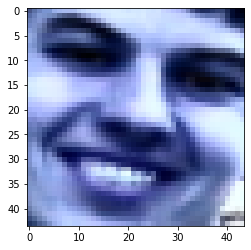

In [0]:
im = Image.open(path+"04.tga")
im = np.array(im) 
#  im = cv2.equalizeHist(im)
im = hist_equalizer(im)
#im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
temp = cv2.resize(im, (w,h), interpolation = cv2.INTER_AREA) 
plt.imshow(temp)
detector = dlib.get_frontal_face_detector()
detect=detector(temp,1)
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

In [0]:
detect
#shape=predictor(temp,detect[0])
#print(shape)
#plt.imshow(temp)

rectangles[]

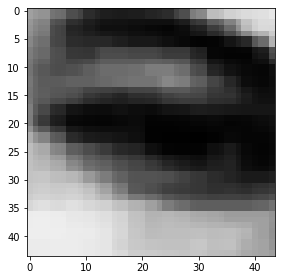

In [0]:
gomgoz=[]
for (x,y,w,h) in seleyes:
    gomgoz.append(temp[y:y+h, x:x+w])
imageio.imshow(gomgoz[0])


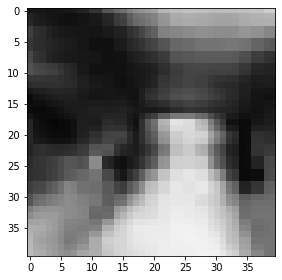

In [0]:
x1l=shape.part(36).x
x2l=shape.part(39).x
#43 46
y1l=shape.part(37).y
y2l=shape.part(40).y
print("{1} : {2} {3} : {4}",x1,x2,y1,y2)

gozdlib=temp[x1:x2,y2:y1]

imageio.imshow(gozdlib)

x1r=shape.part(42).x
x2r=shape.part(45).x
#43 46
#44 47
y1r=shape.part(44).y
y2r=shape.part(47).y
print(x1,x2,y1,y2)
franssag2=rgb[y1:y2,x1:x2]
imageio.imshow(franssag2)

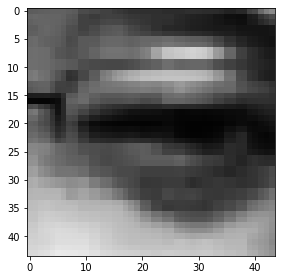

In [0]:
imageio.imshow(gozler[1])

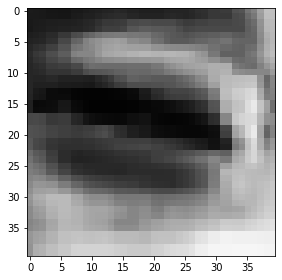

In [0]:
imageio.imshow(gozler[2])

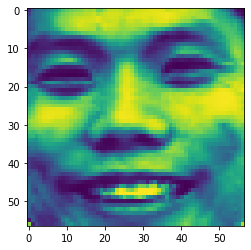

In [0]:
plt.imshow(temp)

## Digression: Comparision of speed of PCA on CPU and GPU

-- GPU wins for large training data, CPU for small ones

In [0]:
device = torch.device("cuda")
all_images = torch.cat((torch.tensor(train_images), torch.tensor(val_images)),0)
all_images = torch.tensor(all_images)
all_images = all_images.to(device)

In [0]:
%%time
X_torch, C_torch, M_torch, Y_torch = pca_PyTorch(all_images, n_pc=n_components) # C -> (50,4096) P -> (360,50) M -> (1,4096) Y -> (360,4096)

In [0]:
X_torch = X_torch.to("cpu")
C_torch = C_torch.to("cpu")
M_torch = M_torch.to("cpu")
Y_torch = Y_torch.to("cpu")
X_test_torch = torch.matmul(torch.tensor(test_images)-M_torch,C_torch.T)